# Laboratory work 12
## Extended Kalman filter for navigation and tracking
## Group 1: Viktor Liviniuk, Alina Liviniuk
## Skoltech
## 2017

The objective of this laboratory work is to develop Extended Kalman filter for tracking a moving object when measurements and motion model are in different coordinate systems. This will bring about a deeper understanding of main difficulties of practical Kalman filter implementation for nonlinear models.

Generate a true trajectory

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def generate_trajectory(N, T, x0, y0, Vx0, Vy0, sigma_a):
    x = np.zeros(N)
    y = np.zeros(N)
    Vx = np.zeros(N)
    Vy = np.zeros(N)
    ax = np.random.normal(0, sigma_a, N)
    ay = np.random.normal(0, sigma_a, N)
    # initial conditions
    x[0] = x0
    y[0] = y0
    Vx[0] = Vx0
    Vy[0] = Vy0
    for i in range(1, N):
        x[i] = x[i - 1] + Vx[i - 1] * T + ax[i - 1] * T**2 / 2
        y[i] = y[i - 1] + Vy[i - 1] * T + ay[i - 1] * T**2 / 2
        Vx[i] = Vx[i - 1] + ax[i - 1] * T
        Vy[i] = Vy[i - 1] + ay[i - 1] * T
    return [x,Vx,y,Vy]

In [3]:
N = 500
T = 1
x0 = y0 = 1000
Vx0 = Vy0 = 10
sigma_a = 0.3

[x,Vx,y,Vy] = generate_trajectory(N, T, x0, y0, Vx0, Vy0, sigma_a)

In [4]:
# Create time list
Time = range(0, N * T, T)

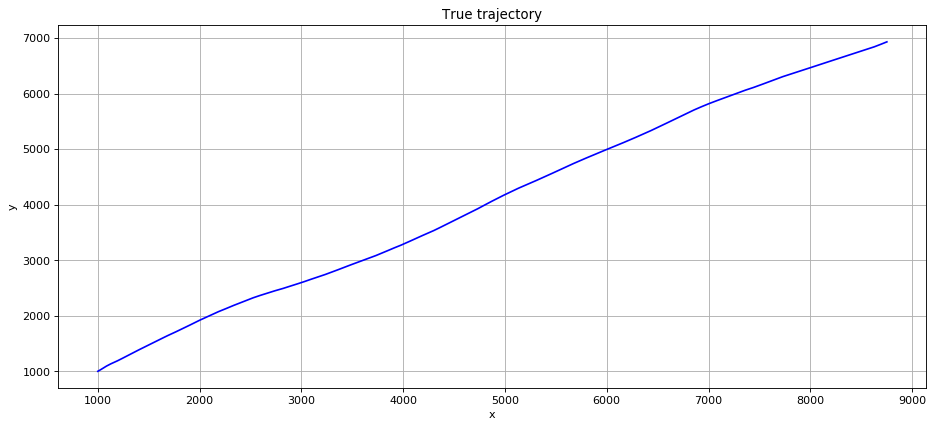

In [5]:
# Plot
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(x, y, "b-")
plt.title('True trajectory')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Change to polar coordinate system. 

In [6]:
from math import atan
from math import sqrt
# Generate true values of range D and azimuth b 
def change_to_polar(x,y):
    N = len(x)
    D = np.zeros(N)
    b = np.zeros(N)
    for i in range(N):
        D[i] = sqrt(x[i]**2 + y[i]**2)
        b[i] = atan(x[i] / y[i])
    return [D, b]

In [7]:
[D, b] = change_to_polar(x,y)

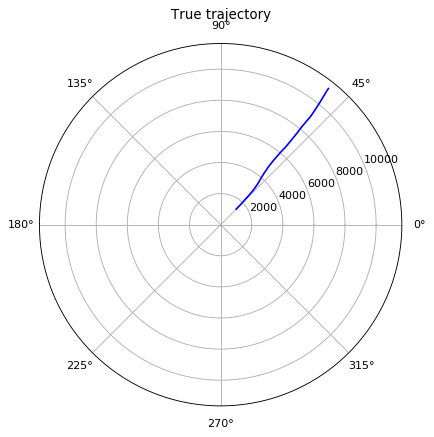

In [8]:
# Plot
plt.figure(figsize=(6, 6), dpi=80)
plt.polar(b, D, "b-")
plt.title('True trajectory')
plt.show()

Generate measurements of the coordinate

In [9]:
sigmaD = 50
sigmab = 0.0004

In [10]:
# Generate measurements Dm and bm of range 𝐷 and azimuth b
def generate_measurements(N, D, b, sigmaD, sigmab):
    etaD = np.random.normal(0, sigmaD, N)
    etab = np.random.normal(0, sigmab, N)

    Dm = np.zeros(N)
    bm = np.zeros(N)
    for i in range(N):
        Dm[i] = D[i] + etaD[i]
        bm[i] = b[i] + etab[i]
        
    return [Dm, bm]

In [11]:
[Dm, bm] = generate_measurements(N, D, b, sigmaD, sigmab)

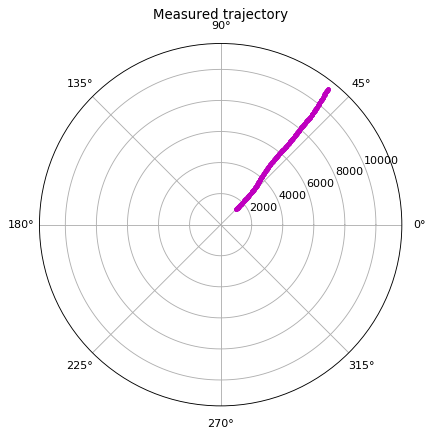

In [12]:
# Plot
plt.figure(figsize=(6, 6), dpi=80)
plt.polar(bm, Dm, "m.")
plt.title('Measured trajectory')
# plt.ylim(9000,14000)
plt.show()

Transform measurements polar coordinates to Cartesian ones and get pseudo-measurements xpm and ypm of coordinates.

In [13]:
def polar_to_cartesian(Dm, bm):
    N = len(Dm)
    xpm = np.zeros(N)
    ypm = np.zeros(N)
    for i in range(N):
        xpm[i] = Dm[i] * np.sin(bm[i])
        ypm[i] = Dm[i] * np.cos(bm[i])
    return [xpm, ypm]

In [14]:
[xpm, ypm] = polar_to_cartesian(Dm, bm)

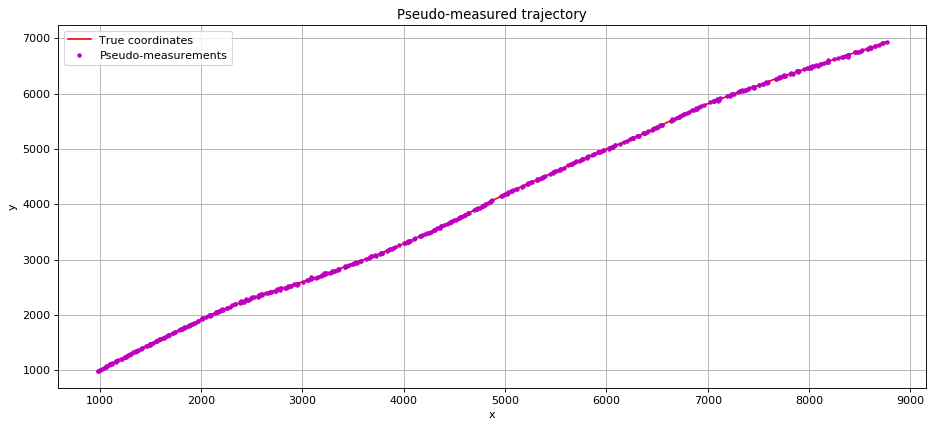

In [15]:
# Plot
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(x, y, 'r-', label='True coordinates')
plt.plot(xpm, ypm, 'm.', label='Pseudo-measurements')
plt.title('Pseudo-measured trajectory')
plt.grid()
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Now an Extended Kalman Filter will be developed and implied

In [16]:
# Create a list of measurement vectors z=[[D],[b]]
def create_z(Dm, bm):
    N = len(xpm)
    return [np.array([[Dm[i]], [bm[i]]]) for i in range(N)]

In [17]:
z = create_z(Dm, bm)

In [18]:
def h(X):
    rr = X[0][0]**2+X[2][0]**2
    return [[rr**.5],[atan(X[0][0]/X[2][0])]]
def dh_d(X):
    rr = X[0][0]**2+X[2][0]**2
    return [[X[0][0]/rr**.5,0,X[2][0]/rr**.5,0],[X[2][0]/rr,0,-X[0][0]/rr,0]]

# Kalman Filter
def KalmanFilter(Zm, Xf0, P00, F, G, Q, R, T):
    "returns Kalman filter estimates Xf and Xp (state vectors filtration and prediction) of given measurements Zm"
    N = len(Zm)
    Xp = []
    Xp.append(Xf0)
    Xf = []
    Xf.append(Xf0)
    Ft = np.transpose(F)
    I = np.eye(4)
    K = []
    Pp = []
    Pp.append(P00)
    Pf = []
    Pf.append(P00)
    for i in range(N-1):
        # prediction
        Xp.append(np.matmul(F, Xf[i]))
        Pp.append(np.matmul(np.matmul(F, Pf[i]), Ft) + Q)
        # filtration
        dh_dX = dh_d(Xp[i+1])
        dh_dX_T = np.transpose(dh_dX)
        K.append(np.matmul(Pp[i+1], np.matmul(dh_dX_T, np.linalg.inv(np.matmul(np.matmul(dh_dX, Pp[i+1]), dh_dX_T) + R))))
        Xf.append(Xp[i+1] + np.matmul(K[-1], z[i+1] - h(Xp[i+1])))
        Pf.append(np.matmul(I - np.matmul(K[-1], dh_dX), Pp[i+1]))
    return [Xf, Xp, Pf, Pp];

In [19]:
# set initial values
X0 = np.array([[Dm[0]*np.sin(bm[0])], [0], [Dm[0]*np.cos(bm[0])], [0]])
P00 = np.eye(4) * 10 ** 10;

In [20]:
# Create the transition matrix F, input matrix G and observation matrix H
F = np.array([[1, T, 0, 0], [0, 1, 0, 0], [0, 0, 1, T], [0, 0, 0, 1]])
G = np.array([[T**2/2, 0], [T, 0], [0, T**2/2], [0, T]])
Q = np.matmul(G, G.transpose()) * sigma_a**2
R = [[sigmaD**2,0],[0,sigmab**2]]

In [21]:
[Xf, Xp, Pf, Pp] = KalmanFilter(z, X0, P00, F, G, Q, R, T)

In [22]:
# transform X to Z and change format for more convinient plotting
def XtoZ(Xf, Xp):
    Zf = np.array([[Xf[i][0][0] for i in range(N)], [Xf[i][2][0] for i in range(N)]])
    Zp = np.array([[Xp[i][0][0] for i in range(N)], [Xp[i][2][0] for i in range(N)]])
    return [Zf, Zp]

In [23]:
[Zf, Zp] = XtoZ(Xf, Xp)

In [24]:
# Calculate D and b from Zp and Zf
def calc_D_b(Zf, Zp):
    Df = []
    Dp = []
    bf = []
    bp = []
    N = len(Zf[0])
    for i in range(N):
        Df.append((Zf[0][i]**2 + Zf[1][i]**2)**.5)
        Dp.append((Zp[0][i]**2 + Zp[1][i]**2)**.5)
        bf.append(atan(Zf[0][i]/(Zf[1][i])))
        bp.append(atan(Zp[0][i]/(Zp[1][i])))
    return [Df, Dp, bf, bp]

In [25]:
[Df, Dp, bf, bp] = calc_D_b(Zf, Zp)

## Visualisation

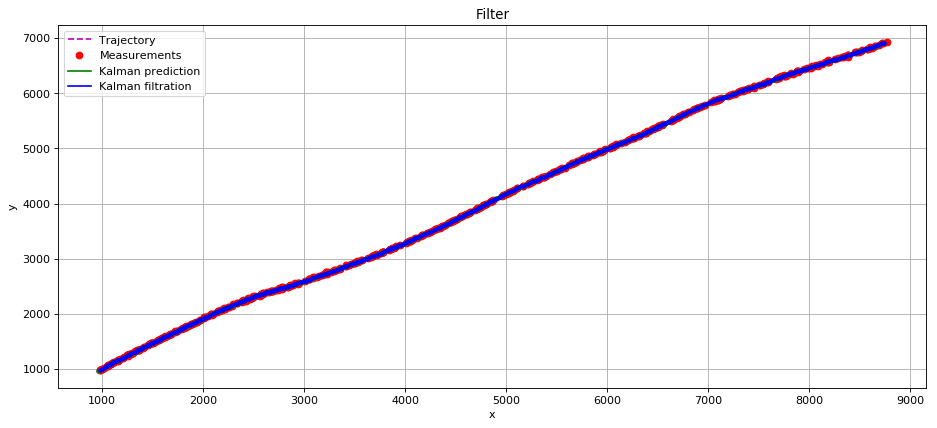

In [26]:
# Plot x-y
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(x, y, 'm--', label = "Trajectory")
plt.plot(xpm, ypm, 'ro', label = "Measurements")
plt.plot(Zp[0], Zp[1], 'g.')
plt.plot(Zp[0], Zp[1], 'g-', label = "Kalman prediction")
plt.plot(Zf[0], Zf[1], 'b.')
plt.plot(Zf[0], Zf[1], 'b-', label = "Kalman filtration")

plt.grid()
plt.legend()
plt.title('Filter')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

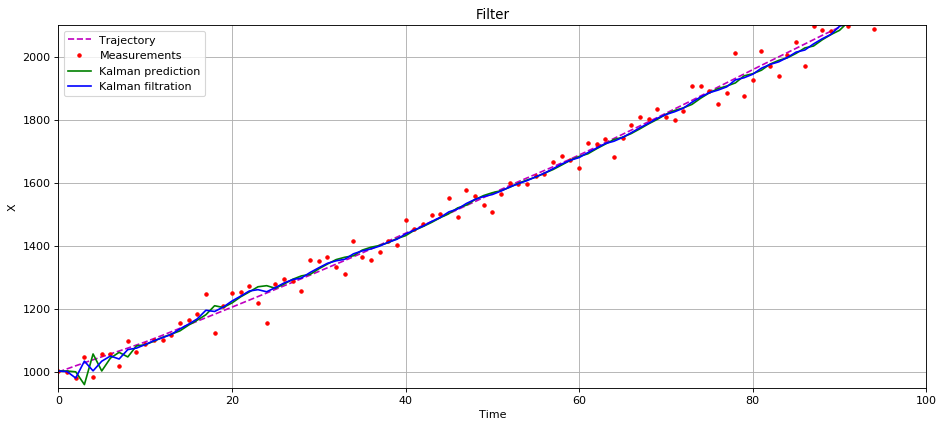

In [27]:
# Plot x
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(Time, x, 'm--', label = "Trajectory")
plt.plot(Time, xpm, 'r.', label = "Measurements")
plt.plot(Time, Zp[0], 'g-', label = "Kalman prediction")
plt.plot(Time, Zf[0], 'b-', label = "Kalman filtration")

plt.grid()
plt.legend()
plt.title('Filter')
plt.xlabel('Time')
plt.ylabel('X')
plt.xlim(0,100)
plt.ylim(950,2100)
plt.show()

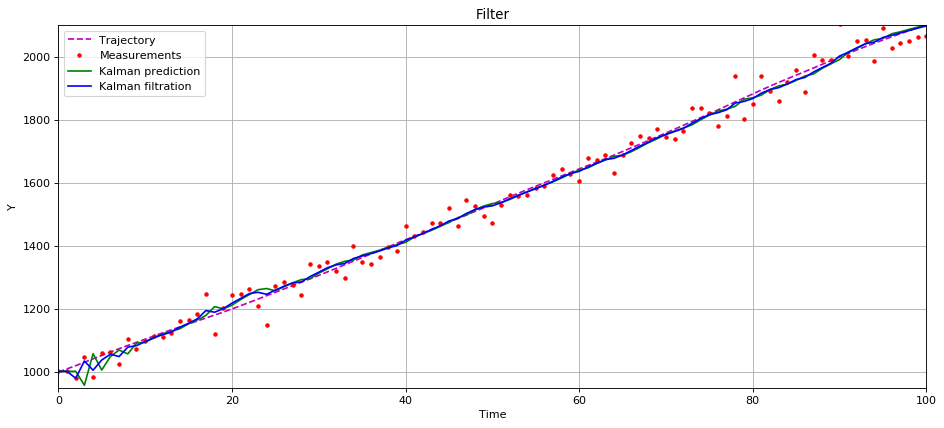

In [28]:
# Plot y
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(Time, y, 'm--', label = "Trajectory")
plt.plot(Time, ypm, 'r.', label = "Measurements")
plt.plot(Time, Zp[1], 'g-', label = "Kalman prediction")
plt.plot(Time, Zf[1], 'b-', label = "Kalman filtration")

plt.grid()
plt.legend()
plt.title('Filter')
plt.xlabel('Time')
plt.ylabel('Y')
plt.xlim(0,100)
plt.ylim(950,2100)
plt.show()

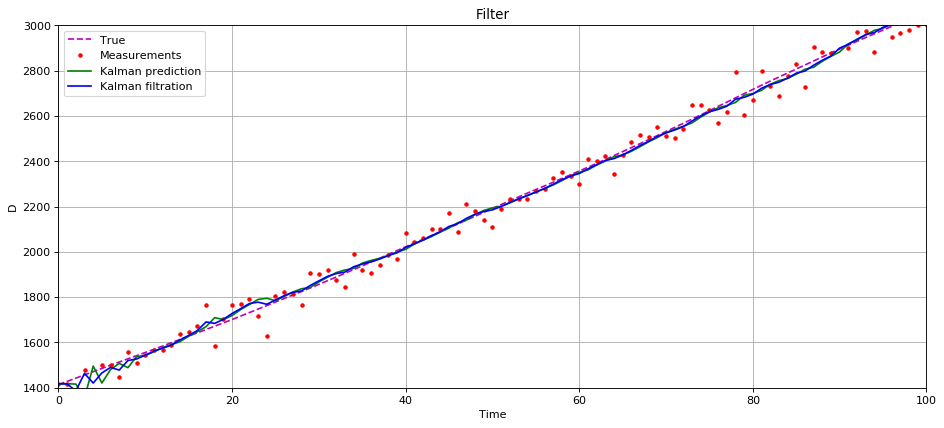

In [29]:
# Plot D
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(Time, D, 'm--', label = "True")
plt.plot(Time, Dm, 'r.', label = "Measurements")
plt.plot(Time, Dp, 'g-', label = "Kalman prediction")
plt.plot(Time, Df, 'b-', label = "Kalman filtration")

plt.grid()
plt.legend()
plt.title('Filter')
plt.xlabel('Time')
plt.ylabel('D')
plt.xlim(0,100)
plt.ylim(1400,3000)
plt.show()

## M = 500 runs and error of estimation calculation

In [30]:
# Errors
def errors_run(t, v):
    "returns errors of estimation e of variable v"
    return (t - v) ** 2

In [31]:
# M runs
M = 500
ErrorRunDf = []
ErrorRunDp = []
ErrorRunbf = []
ErrorRunbp = []
for i in range(M):
    [x,Vx,y,Vy] = generate_trajectory(N, T, x0, y0, Vx0, Vy0, sigma_a)
    [D, b] = change_to_polar(x,y)
    [Dm, bm] = generate_measurements(N, D, b, sigmaD, sigmab)
    z = create_z(Dm, bm)
    [Xf, Xp, Pf, Pp] = KalmanFilter(z, X0, P00, F, G, Q, R, T)
    [Zf, Zp] = XtoZ(Xf, Xp)
    [Df, Dp, bf, bp] = calc_D_b(Zf, Zp)
    ErrorRunDf.append(errors_run(D, Df))
    ErrorRunDp.append(errors_run(D, Dp))
    ErrorRunbf.append(errors_run(b, bf))
    ErrorRunbp.append(errors_run(b, bp))

In [32]:
# Final Error Calculation
Final_Error_Df = (np.sum(ErrorRunDf, axis=0) / (M - 1)) ** .5
Final_Error_Dp = (np.sum(ErrorRunDp, axis=0) / (M - 1)) ** .5
Final_Error_bf = (np.sum(ErrorRunbf, axis=0) / (M - 1)) ** .5
Final_Error_bp = (np.sum(ErrorRunbp, axis=0) / (M - 1)) ** .5

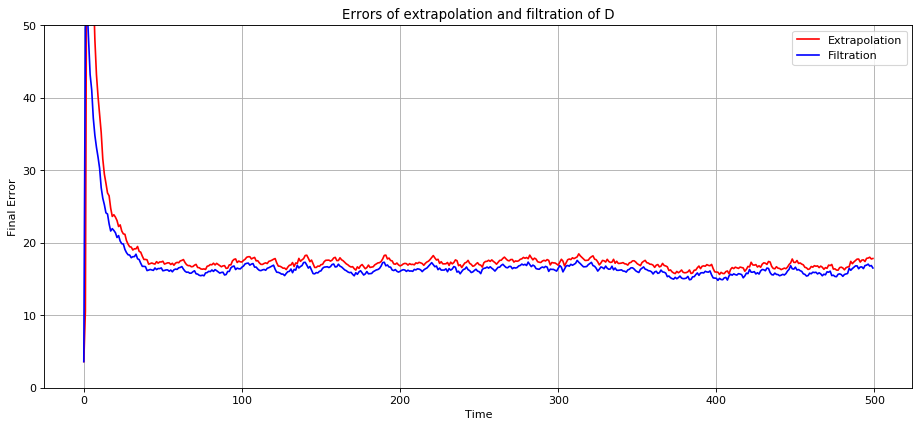

In [33]:
# Plot
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(Time, Final_Error_Dp, 'r-', label = "Extrapolation")
plt.plot(Time, Final_Error_Df, 'b-', label = "Filtration")

plt.grid()
plt.legend()
plt.title('Errors of extrapolation and filtration of D')
plt.xlabel('Time')
plt.ylabel('Final Error')
plt.ylim(0, 50)
plt.show()

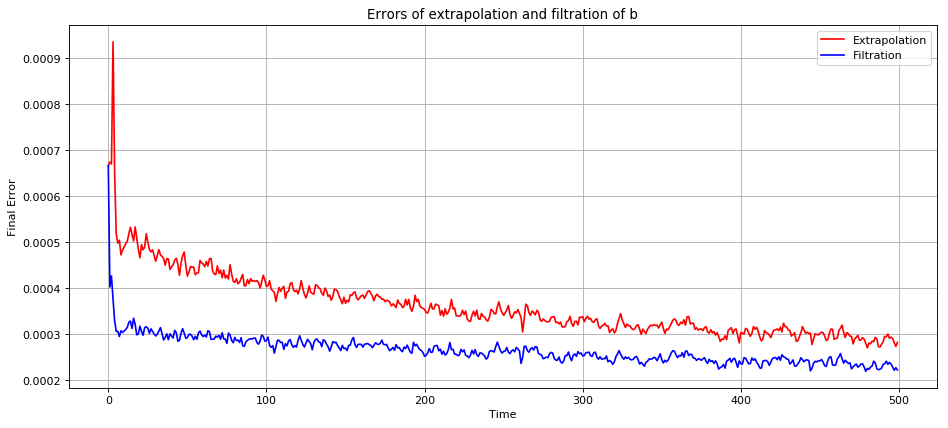

In [34]:
# Plot
plt.figure(figsize=(14, 6), dpi=80)
plt.plot(Time, Final_Error_bp, 'r-', label = "Extrapolation")
plt.plot(Time, Final_Error_bf, 'b-', label = "Filtration")

plt.grid()
plt.legend()
plt.title('Errors of extrapolation and filtration of b')
plt.xlabel('Time')
plt.ylabel('Final Error')
plt.show()

We used measurement errors:
sigmaD = 50
sigmab = 0.0004
Estimation Errors are less then 20 for D and 0.0003 for b (at the end), which is less than measurement errors. For D accuracy approved a lot (almost 3 times).

## Conclusions
Sometimes in practice measurements and motion model are in different coordinate systems. In this particular example, measurements where done in polar coordinates (or similar). Extended Kalman filter for nonlinear models was implemented for processing such kind of data.